In [1]:
!pip install mediapy gamepy moviepy numpy gym matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
  Created wheel for gamepy: filename=gamepy-0.1.5-py3-none-any.whl size=4273 sha256=e8c162c11c579225b303430e9949f343537087f704645f9a5865213bbb203be9
  Stored in directory: /root/.cache/pip/wheels/27/58/8d/bf946d3d1e5e4d37a47b862e607be93f1343e1a750f436e9c0
Successfully built gamepy


### Policy Iteration

In [2]:
import gym,time
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
from moviepy.video.io.bindings import mplfig_to_npimage
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))

gym:[0.25.2]
numpy:[1.23.5]
matplotlib:[3.7.1]


/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


Helper Function

In [3]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    if len(np.shape(img)) == 4:
        img = img[0]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img

def visualize_matrix(M,strs='',figsize=(4,4),fontsize=15,
                     cmap='turbo',title='Title',title_fs=15,REMOVE_TICK_LABELS=True,
                     PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]

    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=1.05)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


###Initialize Environment

In [4]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
env.reset()
print ("[%s] initialized."%(env.unwrapped.spec.id))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[FrozenLake8x8-v1] initialized.


In [5]:
obs_space = env.observation_space
n_state = obs_space.n
action_space = env.action_space
n_action = action_space.n
print("State space:[%d]"%(n_state))
print("Action space:[%d]"%(n_action))

State space:[64]
Action space:[4]


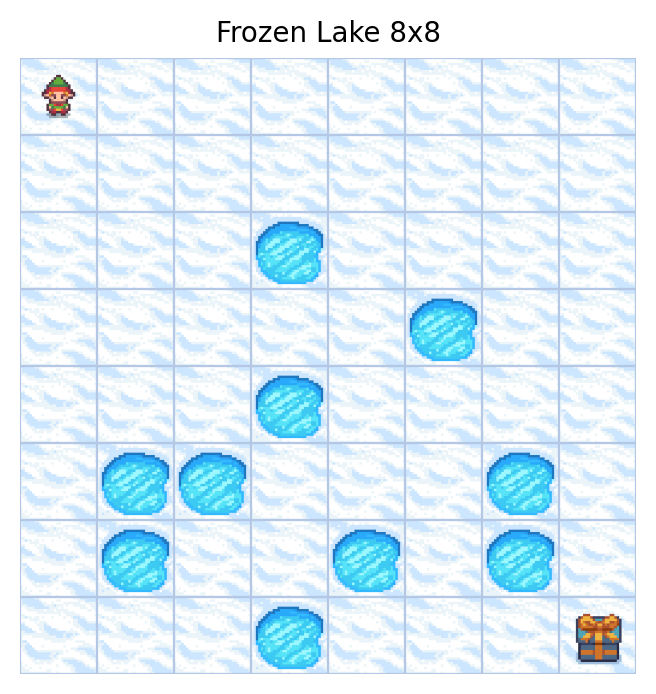

In [6]:
plot_env(env,figsize=(4,4),title_str='Frozen Lake 8x8',title_fs=10)

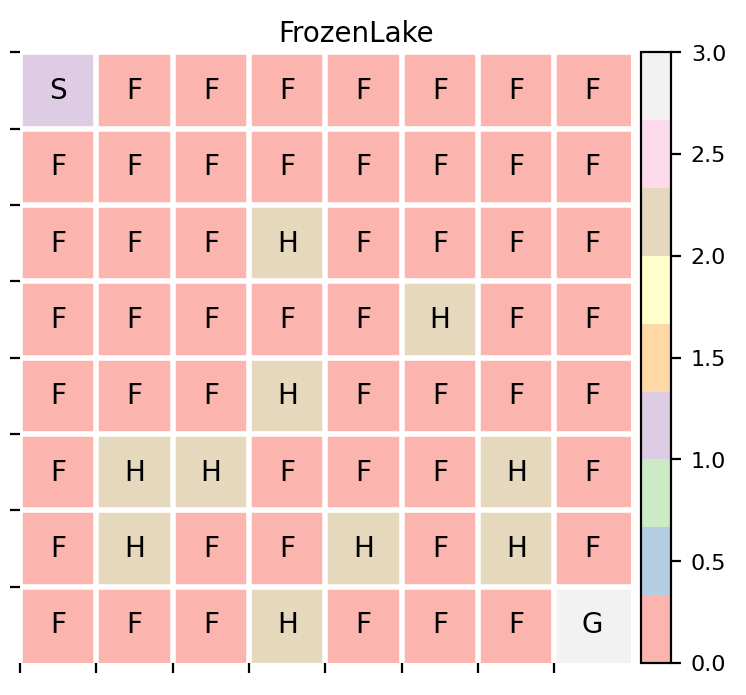

In [7]:
M = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
M[0,0] = 1 # Start
M[2,3]=M[3,5]=M[4,3]=M[5,1]=M[5,2]=M[5,6]=M[6,1]=M[6,4]=M[6,6]=M[7,3]=2 # Hole
M[7,7] = 3 # Goal
visualize_matrix(M,figsize=(4,4),fontsize=10,title_fs=10,
                 strs=strs,cmap='Pastel1',title='FrozenLake',
                 PLOT_IMG=True,RETURN_IMG=False)

### Initial Policy $\pi_0(\cdot|s)$

In [8]:
def plot_policy(Pi,figsize=(4,4),title='Policy',title_fs=10,subplots_top=1.05,
                REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize Policy
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(np.ones((8,8,3)),extent=(0,8,8,0),cmap='Reds')
    ax.set_xticks(np.arange(0,8,1))
    ax.set_yticks(np.arange(0,8,1))
    ax.grid(color='k', linewidth=1)
    ax.set_frame_on(False)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0:
                plt.arrow(j+0.5,i+0.5,-arr_len,0,color="r",alpha=Pi[s][0],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0:
                plt.arrow(j+0.5,i+0.5,0,arr_len,color="r",alpha=Pi[s][1],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0:
                plt.arrow(j+0.5,i+0.5,arr_len,0,color="r",alpha=Pi[s][2],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0:
                plt.arrow(j+0.5,i+0.5,0,-arr_len,color="r",alpha=Pi[s][3],
                          width=0.01,head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im.set_clim(vmin=0,vmax=1) # Reds
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


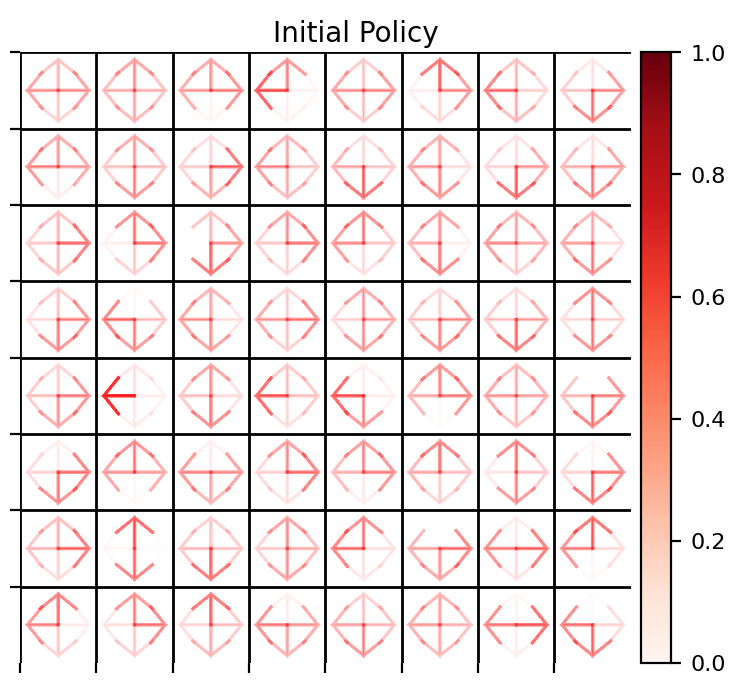

In [9]:
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
np.set_printoptions(precision=3,suppress=True)
plot_policy(Pi,title='Initial Policy',title_fs=10,subplots_top=1.05)

### Policy Evaluation
It compute the value function for a fixed policy $\pi$.

Following Bellman expectation equation for $V_{\pi}$ is used:

$
V_{\pi}(s)
=
\sum_a
\pi(a|s)
\sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi}(s')
\right]
P(s'|s,a)
$

In [10]:
def policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6):
    """
    Policy Evaluation
    """
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P
    # Random initial value function
    V = np.random.uniform(size=(n_state,1))
    # Loop
    tick,V_dists,V_list = 0,[],[]
    while True:
        tick = tick + 1
        V_prime = np.zeros((n_state,))
        for s in P.keys(): # for all state
            for a in P[s].keys(): # for all actions
                for prob,s_prime,reward,done in P[s][a]:
                    V_prime[s] += (reward+gamma*V[s_prime])*prob*Pi[s][a]
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime
        V_list.append(V)
        if V_dist < epsilon:
            break
    return V,V_dists,V_list

def plot_pi_v(Pi,V,figsize=(4,4),title='Value Function',cmap='turbo',
              title_fs=10,subplots_top=1.05,
              REMOVE_TICK_LABELS=True,PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


### Run policy evaluation

In [11]:
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
start = time.time()
V,V_dists,V_list = policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6)
print("It took [%.2f]s."%(time.time()-start))
print ("Policy evaluation converged in [%d] loops."%(len(V_dists)))
print ("Done.")

It took [0.59]s.
Policy evaluation converged in [913] loops.
Done.


Plot the convergence of value iteration

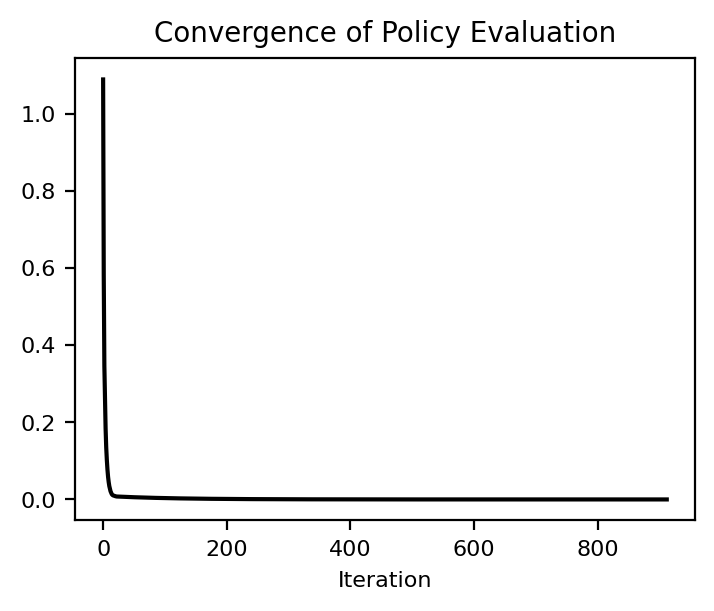

In [12]:
plt.figure(figsize=(4,3))
plt.plot(V_dists,'k-')
plt.xlabel('Iteration',fontsize=8)
plt.title("Convergence of Policy Evaluation",fontsize=10)
plt.show()

Plot how value function changes over iteration

In [13]:
n_plot = 50
frames = []
for itr in np.round(np.linspace(0,len(V_list)-1,n_plot)).astype(np.int32):
    V = V_list[itr]
    img = plot_pi_v(
        Pi,np.reshape(V,(8,8)),cmap='binary',title="Value Function@iter=%d"%(itr),
        title_fs=10,PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
media.show_video(frames, fps=5)
print ("Done.")

Done.


### This is how one step policy evaluation works

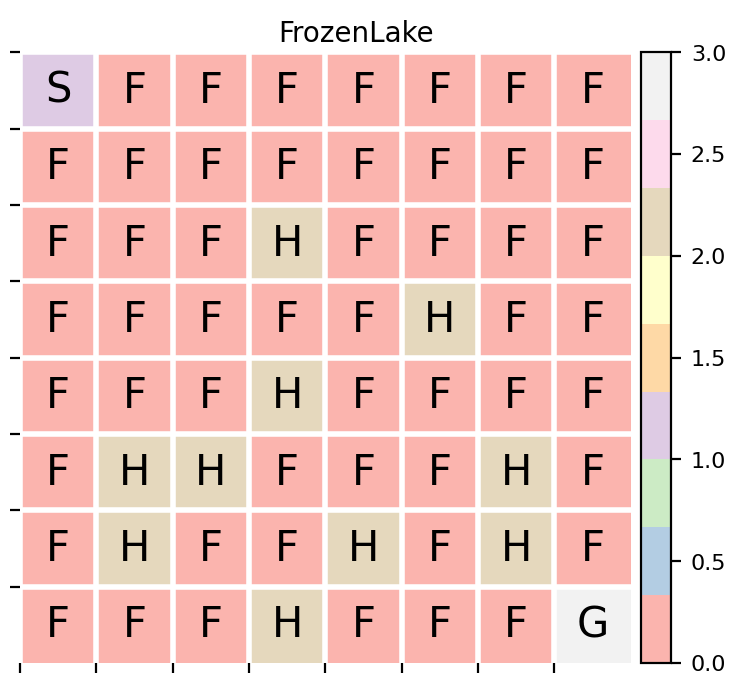

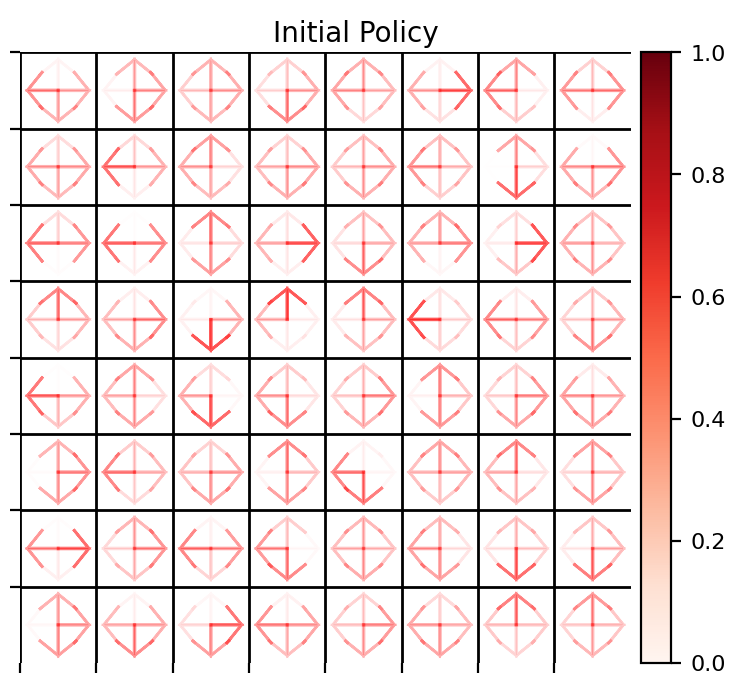

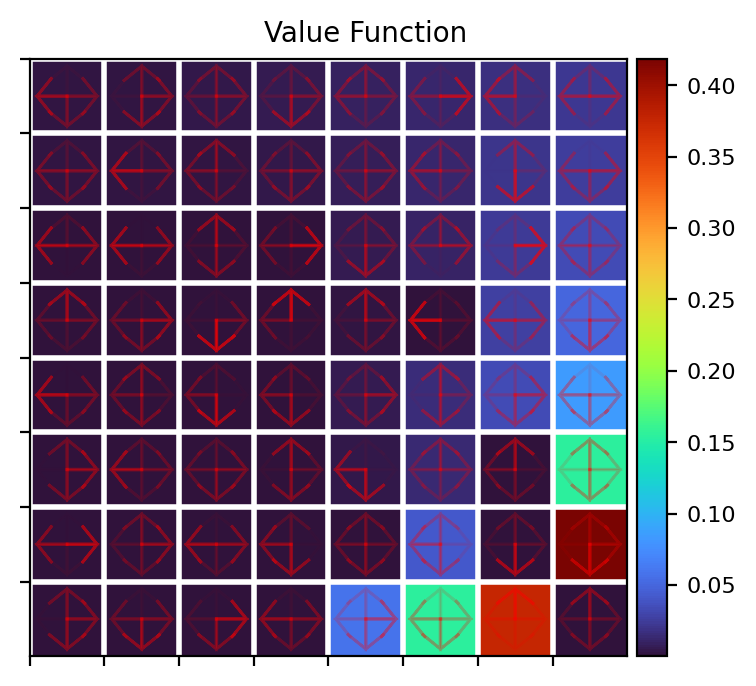

In [14]:
# Environment
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake',title_fs=10)

# Initial policy
Pi = np.random.uniform(size=(n_state,n_action))
Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
np.set_printoptions(precision=3,suppress=True)
plot_policy(Pi,title='Initial Policy',title_fs=10)

# Run policy evaluation
V,V_dists,V_list = policy_evaluation(env,Pi,gamma=0.99,epsilon=1e-6)
plot_pi_v(Pi,np.reshape(V,(8,8)),
          title='Value Function',cmap='turbo',title_fs=10,REMOVE_TICK_LABELS=True)

### Policy Improvement
In this step, we update the policy distribution using the value function computed by policy evaluation. A new policy distribution is updated greedly as follows:

$Q_{\pi_k}(s,a) = \sum_{s'}
\left[
r(s,a,s') + \gamma V_{\pi_k}(s')
\right]
P(s'|s,a)
$

$\pi_{k+1} = \arg \max_a Q_{\pi_k}(s,a)$

In [15]:
def policy_improvement(env,V,gamma=0.99):
    """
    Policy Improvement
    """
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    P = env.unwrapped.P
    Q = np.zeros((n_state,n_action))
    # Loop
    for s in P.keys(): # for all states
        for a in P[s].keys(): # for all actions
            for prob,s_prime,reward,done in P[s][a]:
                Q[s,a] += (reward + gamma*V[s_prime])*prob
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    return Pi
print ("Ready.")

Ready.


### Run policy improvement on the value achieved from policy evaluation

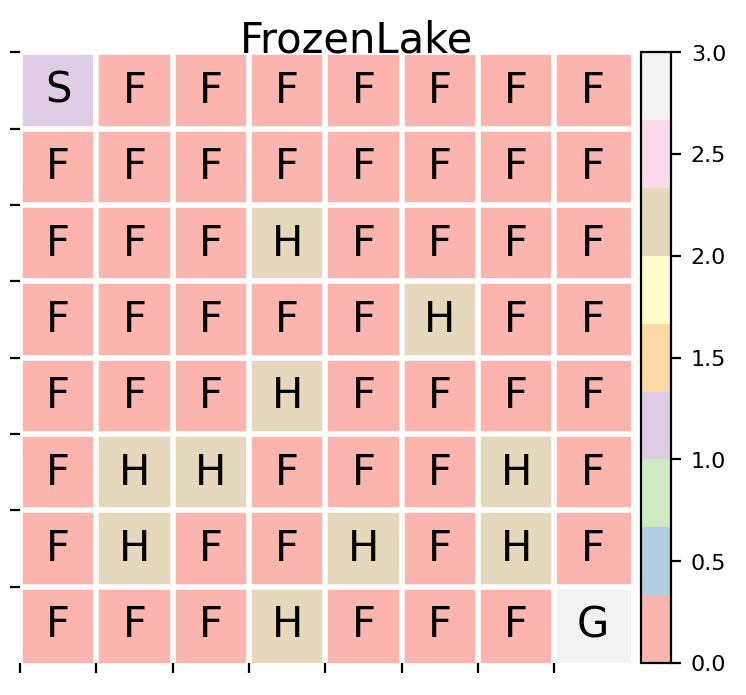

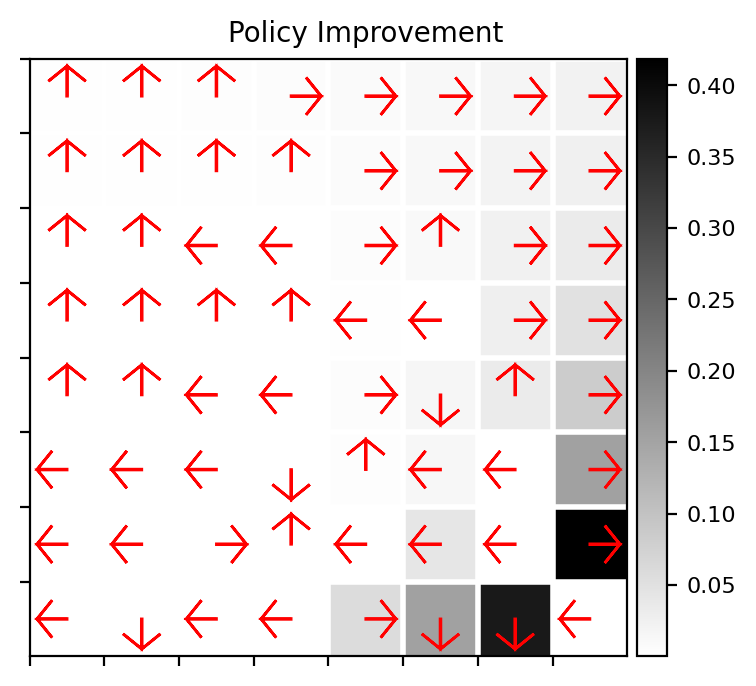

In [16]:
Pi = policy_improvement(env,V)
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')
plot_pi_v(Pi,np.reshape(V,(8,8)),cmap='binary',title="Policy Improvement")

### Finally, Policy Iteration
Policy iteration iterates `policy evaluation` and `policy improvement`.
1. Randomly initialize the policy distribution
2. Compute the value function by `policy evaluation`
3. Update the policy by `policy improvement`
4. If the policy distribution does not change, then `stop`. Otherwise, repeat (2)~(3).

In [17]:
def policy_iteration(env,gamma=0.99,epsilon=1e-6):
    """
    Policy Iteration
    """
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    Pi = np.random.uniform(size=(n_state,n_action))
    Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
    while True:
        V,V_dists,V_list = policy_evaluation(env,Pi,gamma=gamma,epsilon=epsilon)
        Pi_prime = policy_improvement(env,V,gamma=gamma)
        if (Pi == Pi_prime).all(): # if the policy does not change
            break
        Pi = Pi_prime
    return Pi,V
print ("Ready.")

Ready.


### Run Policy Iteration (until convergence)

In [18]:
start = time.time()
gamma = 0.99
Pi,V = policy_iteration(env,gamma=gamma)
print("It took [%.2f]s."%(time.time()-start))

It took [29.19]s.


Plot environment and the results of policy iteration

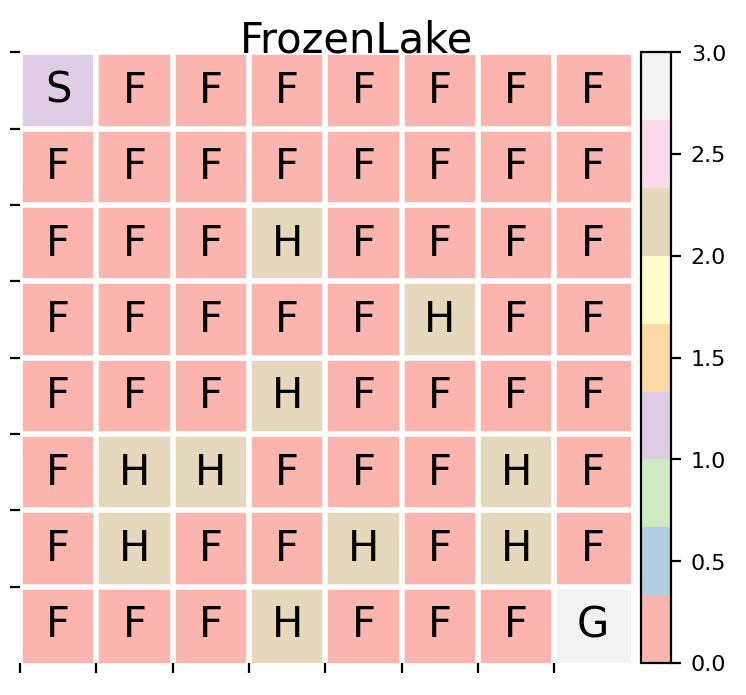

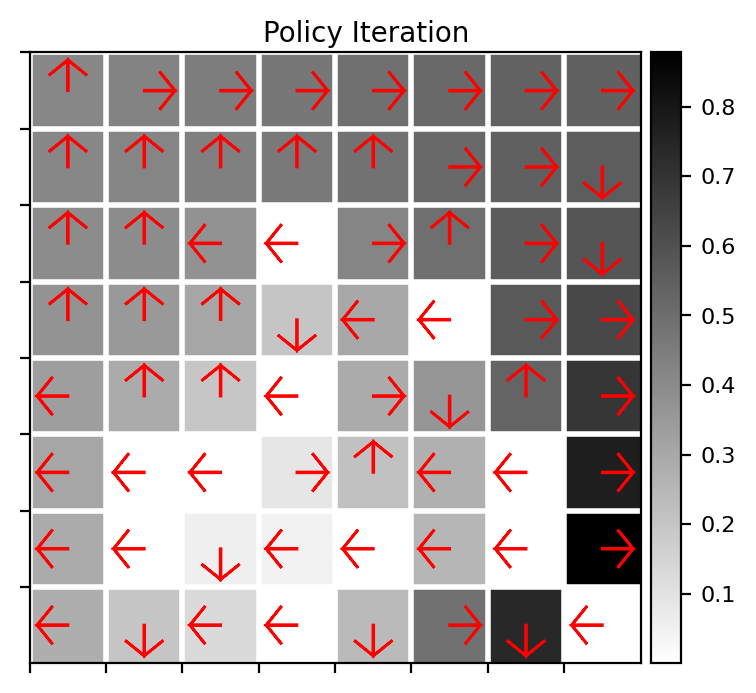

In [19]:
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')
plot_pi_v(Pi,np.reshape(V,(8,8)),cmap='binary',title="Policy Iteration")

Animate the optimal policy

In [21]:
obs = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,truncated = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[25])


In [22]:
media.show_video(frames, fps=5)

Animate random policy

In [24]:
obs = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = env.action_space.sample()
    next_obs,reward,done,truncated = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[50])


In [25]:
media.show_video(frames, fps=5)